# Image Processing SoSe 2024 - Assignment - 02

### Deadline is 02.05.2024 at 12:00 p.m.

#### Students: Minh Tuan Nguyen, Vinzent Hannes Jörß

Please solve the assignments together with a partner.

Make sure the code runs without errors, when clicking `Kernel` -> `Restart Kernel & Run All Cells`. Then save the notebook and upload your submission.

# Exercise 1 - 5 Points
Implement the `rgb_to_hsv` and `hsv_to_rgb` functions. Don't use any color conversion functions from a library.

For hsv_to_rgb I used the formulas from this source: https://www.rapidtables.com/convert/color/hsv-to-rgb.html

In [56]:
def rgb_to_hsv(img):
    """
    Converts the numpy array `img` from RGB to the HSV.
    """
    image = np.copy(img)/ 255.0
    R = image[:, :, 0]
    G = image[:, :, 1]
    B = image[:, :, 2]
    
    height, width, depth = image.shape
    MAX = np.max(image, axis=2)
    MIN = np.min(image, axis=2)
    
    delta = MAX - MIN
    delta_mask = delta != 0
    delta = np.where(delta == 0, 1e-10, delta)
    
    mask_R = (MAX == R) & delta_mask
    mask_G = (MAX == G) & delta_mask
    mask_B = (MAX == B) & delta_mask
    
    #init H
    hue = np.zeros_like(R)
    hue[mask_R] = 60 * (0 + (G-B)/delta)[mask_R]
    hue[mask_G] = 60 * (2 + (B-R)/delta)[mask_G]
    hue[mask_B] = 60 * (4 + (R-G)/delta)[mask_B]    
    hue = hue % 360
    
    #Saturation errechnen
    sat = np.zeros_like(R)
    sat[MAX != 0] = (delta / MAX)[MAX != 0]
    
    #Value errechnen
    value = MAX
    
    return np.stack((hue, sat, value), axis=2)

In [57]:
def hsv_to_rgb(img):
    """
    Converts the numpy array `img` from HSV to the RGB.
    """
    image = np.copy(img)
        
    hue = image[:, :, 0]
    sat = image[:, :, 1]
    value = image[:, :, 2]

    C = value * sat
    X = C * (1 - abs(((hue/60) % 2) - 1))
    m = value - C
    
    rad = 60
    
    mask1 = (0*rad <= hue) & (hue < 1*rad)
    mask2 = (1*rad <= hue) & (hue < 2*rad)
    mask3 = (2*rad <= hue) & (hue < 3*rad)
    mask4 = (3*rad <= hue) & (hue < 4*rad)
    mask5 = (4*rad <= hue) & (hue < 5*rad)
    mask6 = (5*rad <= hue) & (hue < 6*rad)
    
    Rp = np.zeros_like(hue)
    Gp = np.zeros_like(hue)
    Bp = np.zeros_like(hue)

    Rp[mask1], Gp[mask1], Bp[mask1] = C[mask1], X[mask1], 0
    Rp[mask2], Gp[mask2], Bp[mask2] = X[mask2], C[mask2], 0
    Rp[mask3], Gp[mask3], Bp[mask3] = 0, C[mask3], X[mask3]
    Rp[mask4], Gp[mask4], Bp[mask4] = 0, X[mask4], C[mask4]
    Rp[mask5], Gp[mask5], Bp[mask5] = X[mask5], 0, C[mask5]
    Rp[mask6], Gp[mask6], Bp[mask6] = C[mask6], 0, X[mask6]
    
    R = (Rp + m)
    G = (Gp + m)
    B = (Bp + m)
    
    img = np.stack((R, G, B), axis=-1)
    return img

Plot the saturation channel of the cat image

In [58]:
# display the plots inside the notebook
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from skimage.data import cat
import pylab
pylab.rcParams['figure.figsize'] = (12, 12)   # This makes the plot bigger

img = cat() / 255.
img_as_hsv = rgb_to_hsv(img)

plt.imshow(img_as_hsv[:, :, 1], cmap='gray', vmin=0, vmax=1)

Increase the saturation by a factor of 2, convert it back to RGB and plot the result.

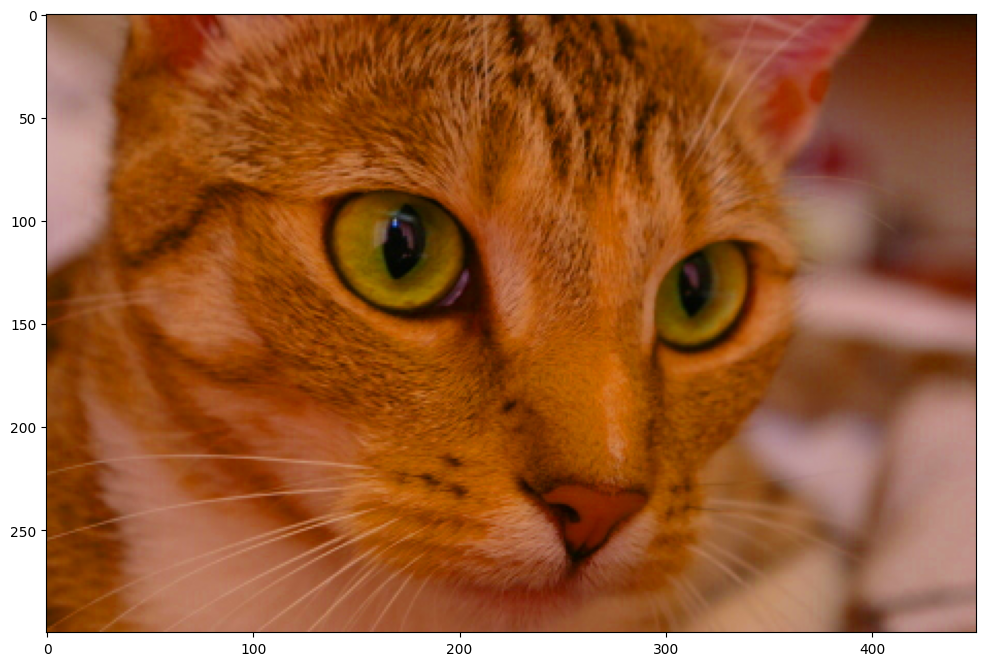

In [59]:
def change_saturation(image, sat_mult):
    img_temp = rgb_to_hsv(image)
    img_temp[:, :, 1] = np.clip((img_temp[:, :, 1] * sat_mult), 0, 1)
    return hsv_to_rgb(img_temp)

plt.imshow(change_saturation(cat(), 2))


# Exercise 2 - 5 Points
Write a function to transform an RGB-image into the YUV color space, and another function to transform the image back (from YUV to RGB).

In [60]:
# we use the BT709 matrices here
# see https://en.wikipedia.org/wiki/YCbCr#ITU-R_BT.709_conversion
rgb_to_ycbcr = np.array([[0.2126, 0.7152, 0.0722],
                         [-0.1146, -0.3854, 0.5],
                         [0.5, -0.4542, -0.0458]])

def rgb_to_yuv(img):
    image = img.copy() @ rgb_to_ycbcr
    return np.clip(image, 0, 1)

Now do the following: Transform the image from the previous task into the YUV-color space. Write a function to perform a 4:2:0 chroma-subsampling, i.e. the chroma channels are for 4 pixels the same, and apply this function. Transform the resulting image back into the RGB-space

In [61]:
def chroma_subsampling(img):
    image = np.copy(img)
    height, width, depth = image.shape
    Y = image[:, :, 0]
    U = image[:, :, 1]
    V = image[:, :, 2]
    
    U_sub = np.zeros_like(U)
    V_sub = np.zeros_like(V)
    
    for i in range(0, height-1, 2):
        for j in range(0, width-1, 2):
            u_sub = np.mean(U[i:i+2, j:j+2])
            v_sub = np.mean(V[i:i+2, j:j+2])
            
            #2x2 Block erhaelt den gleichen gemittelten Wert
            U_sub[i:i+2, j:j+2] = u_sub
            V_sub[i:i+2, j:j+2] = v_sub   
            
    image = np.stack((Y, U_sub, V_sub), axis=-1)
            
    return image

ycbcr_to_rgb = np.array([[1, 0, 1.5748],
                         [1, -0.1873, -0.4681],
                         [1, 1.8556, 0]])

def yuv_to_rgb(img):
    image = np.copy(img) @ ycbcr_to_rgb
    return np.clip(image, 0, 1)

 Plot the original image and the 4:2:0 chroma-subsampled images. Do you see differences and if so, where?
 
 Man kann eindeutig Differenzen zwischen dem rechten und dem linken Bild erkennen. Die Pupillen und Haare der Katze sind im linken Bild detaillierter gezeichnet als im rechten Bild. Auch kontrastreiche Partien, wie die Augenumrandung sind klarer im linken, als im rechten Bild. Unterschiede in unscharfen Bereichen, wie der Hintergrund sind hingegen kaum zu erkennen.

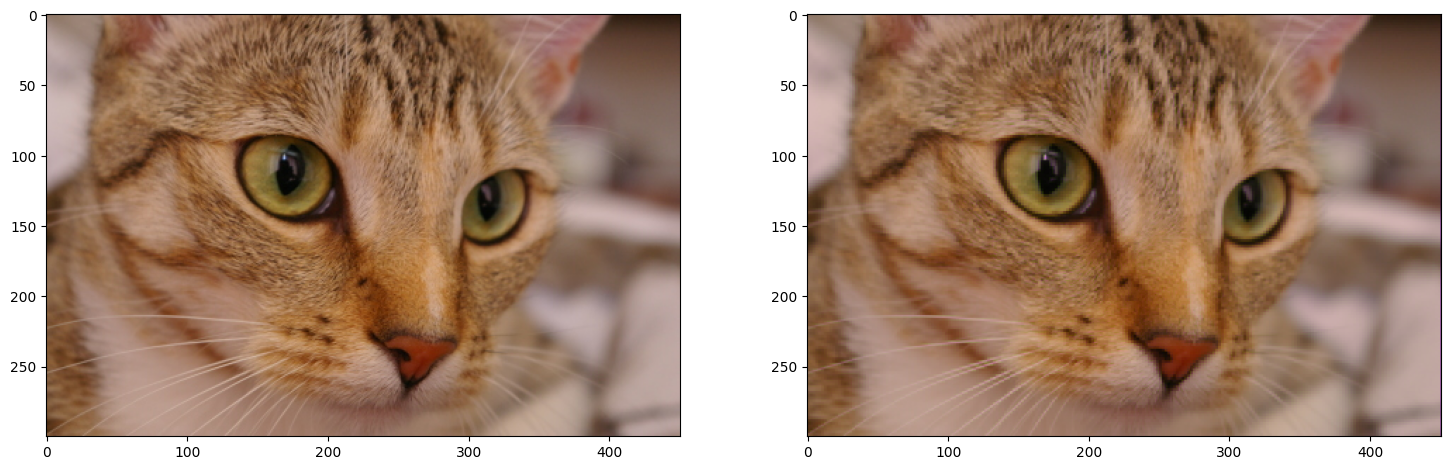

In [63]:
img = cat() / 255.
img_yuv = rgb_to_yuv(img)
img_yuv_420 = chroma_subsampling(img_yuv)
img_rgb = yuv_to_rgb(img_yuv_420)

plt.figure(figsize=(18, 12))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img_rgb)
plt.show()